File used for testing the functions in the repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd

In [2]:
# import predict_polynomial_signal from Predicted_signal.py
from source.Losses import MSE, compute_parameter_loss
from source.Predicted_signal import predict_polynomial
from data.Polynomial_test import generate_polynomial_data
from data.Polynomial_test import load_polynomial_data

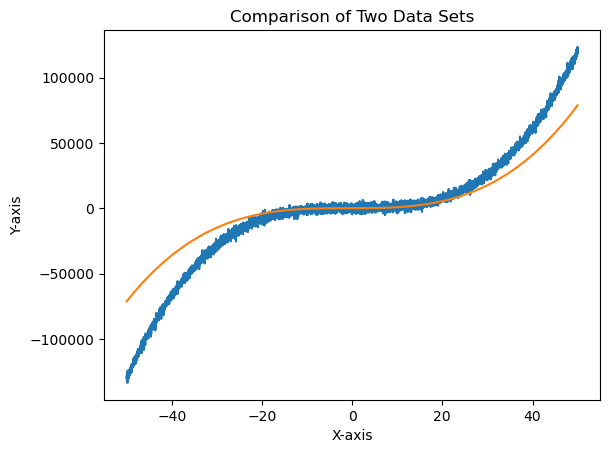

MSE: 376207658.2448702


In [3]:
# Coefficients for the polynomial (a0, a1, a2, a3, a4)
true_coefficients = [250, 2.5, -2, 1]
list = np.linspace(-50, 50, 5000)
estimated_coefficients = [0, 1.2, 1.5, 0.6]

result = generate_polynomial_data(true_coefficients, list, noise_level=2000)
prediction = predict_polynomial(estimated_coefficients, list)

plt.plot(list, result)
plt.plot(list, prediction)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of Two Data Sets')

plt.show()

print("MSE:", MSE(result, prediction))

In [4]:
# Get two tensors

a = np.array([1, 2, 3, 4, -7])
b = np.array([1, 2, 3, 4, 5])

inputs_tensor = torch.tensor(a, dtype=torch.float32)
true_params_tensor = torch.tensor(b, dtype=torch.float32)


print("Parameter Loss:", compute_parameter_loss(inputs_tensor, true_params_tensor))

Parameter Loss: tensor(-2.4000)


In [5]:
print(np.random.randn(4))

[-1.5485239  -0.0853214  -0.28467281  0.05661723]


<h2>Generating simulated data<h2>

In [6]:
from data.Data_simulation import DataLoader

In [7]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/all_data_003.csv')

# Usage example:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.125549, 4.5012, 13.7206, 9.70757, 9.24363, 8.84905, 8.37535, 7.8264, 7.84643, 8.74946, 8.4736, 8.5893, 9.00677, 8.93431, 8.7004, 8.79878, 8.63712, 8.86024, 8.56235, 8.77035, 8.93855, 8.96577], 'gt_parameters_list': [0.13, 0.014, 0.025, 0.05]}


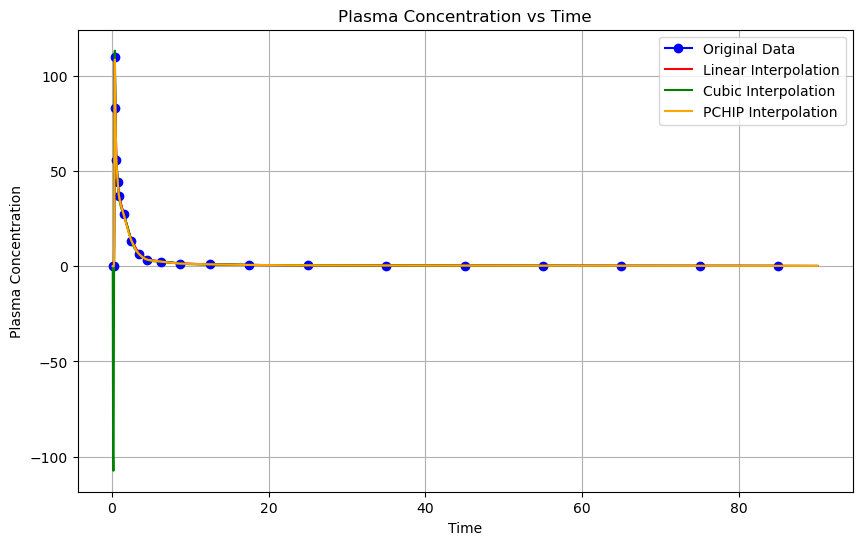

In [10]:
from data.Data_simulation import equidistant_interpolation, plot_interpolations

num_equidistant_points = 2048
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['pl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['pl_list'], 
                    new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

In [11]:
# conver pchip_pl to list
pchip_pl_list = pchip_pl.tolist()

print("Plasma pchip", pchip_pl_list)

Plasma pchip [0.05901, 0.056637675603587824, 0.05547719305326996, 0.05509513570762799, 3.592434735456152, 76.66566845125945, 108.62803110406004, 92.5573429263923, 78.29933675629024, 67.06107825999348, 58.23876098298494, 53.30780720033635, 49.94361870493774, 47.33189895076981, 45.01827907182818, 42.66644589125604, 40.42639914056479, 38.48481140381643, 37.02306282096053, 35.93809850568003, 34.96435713961824, 34.088361050727435, 33.29689371474379, 32.576738607403485, 31.914679204442663, 31.29749898159751, 30.711981414604193, 30.14490997919887, 29.58306815111772, 29.013239406096897, 28.422207219872586, 27.79675506818094, 27.13438050161109, 26.461860587907896, 25.783013193747067, 25.099596898012848, 24.413370279589483, 23.726091917361206, 23.039520390212257, 22.35541427702689, 21.67553215668934, 21.001632608083842, 20.335474210094638, 19.67881554160597, 19.033415181502082, 18.401031708667215, 17.783423701985605, 17.182349740341504, 16.599568402619134, 16.036838267702752, 15.495917914476596,

<h3> IRF <h3>

In [12]:
from data.Data_simulation import IRF

IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)

#print("Parameters:", data_from_first_row['gt_parameters_list'])
print(IRF_values)

[0.12977305363123387, 0.12969360187710305, 0.12961428605361935, 0.12953510592822487, 0.12945606126875941, 0.12937715184346008, 0.12929837742096045, 0.12921973777028992, 0.1291412326608731, 0.12906286186252902, 0.12898462514547054, 0.12890652228030372, 0.1288285530380269, 0.12875071719003045, 0.12867301450809565, 0.12859544476439436, 0.12851800773148817, 0.12844070318232775, 0.12836353089025232, 0.12828649062898878, 0.12820958217265122, 0.12813280529574017, 0.12805615977314191, 0.12797964538012796, 0.1279032618923542, 0.12782700908586042, 0.12775088673706955, 0.12767489462278706, 0.1275990325202001, 0.1275233002068773, 0.1274476974607676, 0.1273722240602, 0.12729687978388263, 0.1272216644109023, 0.1271465777207237, 0.12707161949318893, 0.12699678950851664, 0.12692208754730155, 0.12684751339051373, 0.12677306681949801, 0.12669874761597325, 0.12662455556203184, 0.1265504904401389, 0.12647655203313177, 0.12640274012421926, 0.1263290544969812, 0.1262554949353676, 0.1261820612236981, 0.12610

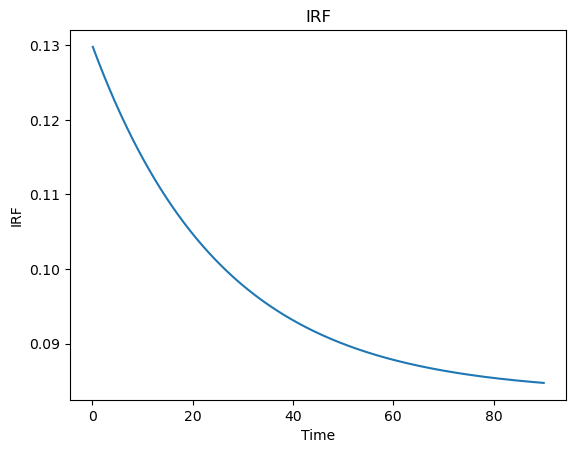

In [14]:
plt.plot(new_rtim, IRF_values)
plt.xlabel('Time')
plt.ylabel('IRF')
plt.title('IRF')
plt.show()

In [15]:
print(data_from_first_row['gt_parameters_list'])

k1 = data_from_first_row['gt_parameters_list'][0]
k2 = data_from_first_row['gt_parameters_list'][1]
k3 = data_from_first_row['gt_parameters_list'][2]
k4 = 0
print((k2 + k3 + k4))
alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha1)
alpha1 /= 2

print(alpha1)

alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha2)
alpha2 /= 2
print(alpha2)

print(np.exp(alpha1*0.1))

[0.13, 0.014, 0.025, 0.05]
0.039
0.0
0.0
0.078
0.039
1.0


In [33]:
def IRF(gt_parameters_list, equidistant_rtim):
    """
    Calculates the impulse response function (IRF) for the given ground truth parameters and equidistant timepoints.

    Parameters:
    gt_parameters_list (list): List of ground truth parameters.
    equidistant_rtim (list): Equidistant timepoints.

    Returns:
    list: The IRF values.
    """
    # Extract ground truth parameters
    k1 = gt_parameters_list[0]
    k2 = gt_parameters_list[1]
    k3 = gt_parameters_list[2]
    k4 = 0 # For the current data, k4 is always 0

    # Calculate alphas:
    alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha1 /= 2

    alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha2 /= 2

    # Calculate IRF
    IRF = []
    for t in equidistant_rtim:
        value = ( (k3 + k4 - alpha1) * np.exp(-alpha1 * t) + (alpha2 - k3 - k4) * np.exp(-alpha2 * t) ) / (alpha2 - alpha1)
        value *= k1
        IRF.append(value)
    
    return IRF

<h2> C Tissue <h2>

In [27]:
def c_tissue(IRF_values, pchip_pl):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add required dimensions for conv1d
    IRF_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # normalize the IRF tensor
    # IRF_tensor = IRF_tensor / torch.norm(IRF_tensor)

    # Perform the convolution using PyTorch's conv1d function
    # The groups argument ensures that each input channel is convolved with its own filter (IRF_tensor)
    result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)

    # Normalize the convolution result
    num_points = len(IRF_values) 
    normalized_result_tensor = result_tensor / np.sqrt(num_points)

    # Remove the extra dimensions and convert the tensor back to a list
    simulated_tac_values = normalized_result_tensor.squeeze().tolist()

    return simulated_tac_values

In [24]:
def c_tissue2(IRF_values, pchip_pl):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add batch and channel dimensions (required for conv1d)
    # The unsqueeze(0) adds a batch dimension and unsqueeze(1) adds a channel dimension.
    irf_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # Perform the convolution
    # The conv1d function expects inputs of size (minibatch, in_channels, iW), where
    # minibatch is the number of input maps, in_channels is the number of channels in the input image,
    # and iW is the width of the input image.
    result_tensor = F.conv1d(pchip_tensor, irf_tensor, padding='same')

    # Normalize the convolution result
    num_points = len(IRF_values) 
    normalized_result_tensor = result_tensor / np.sqrt(num_points)

    # Convert the result back to a list and remove the extra dimensions
    simulated_tac_values = normalized_result_tensor.squeeze().tolist()

    return simulated_tac_values

In [22]:
def c_tissue3(IRF_values, pchip_pl):
    # Convert lists to PyTorch tensors
    irf_tensor = torch.tensor(IRF_values).float().view(1, 1, -1)
    pchip_tensor = torch.tensor(pchip_pl).float().view(1, 1, -1)

    # Check if the IRF tensor length is odd, if not, append a zero
    if irf_tensor.shape[-1] % 2 == 0:
        # Append a zero to make the length odd
        irf_tensor = F.pad(irf_tensor, (0, 1))
    
    # Perform the convolution
    result_tensor = F.conv1d(pchip_tensor, irf_tensor, padding='same')

    # Convert the result back to a list
    simulated_tac_values = result_tensor.squeeze().tolist()

    return simulated_tac_values

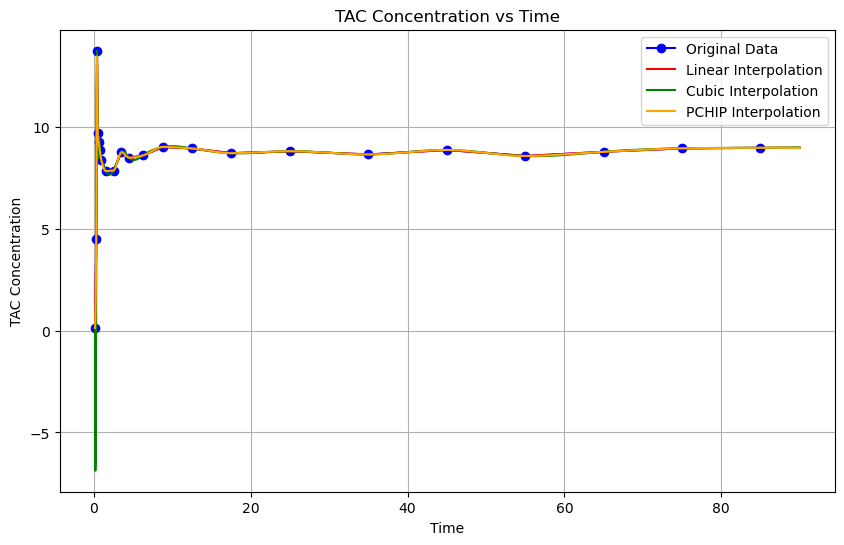

In [17]:
# Get the interpolated tac values
new_rtim, linear_tac, cubic_tac, pchip_tac = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['tac_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['tac_list'], 
                    new_rtim, linear_tac, cubic_tac, pchip_tac, 'TAC')

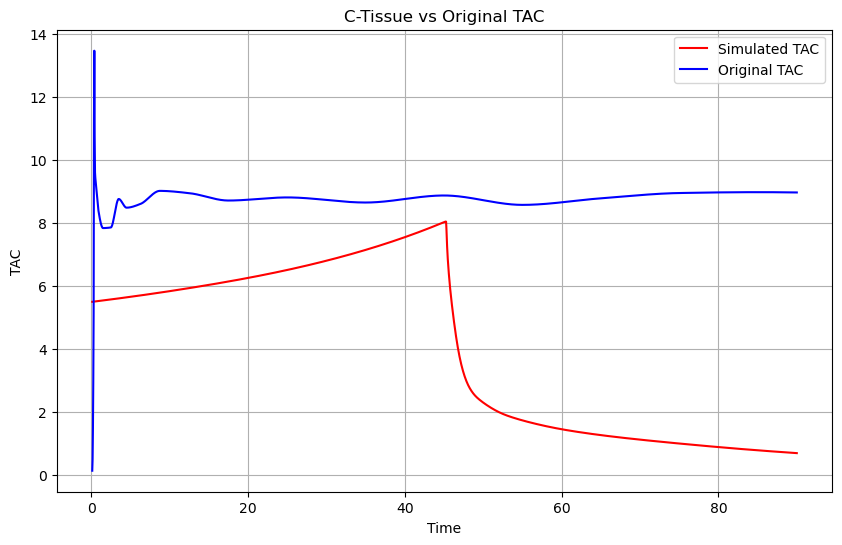

In [46]:
simulated_c_tissue_values = c_tissue(IRF_values, pchip_pl)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

<h3> Numpy <h3>

In [31]:
def c_tissue4(IRF_values, pchip_pl):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """

    # Normalize IRF values
    IRF_values = IRF_values / np.linalg.norm(IRF_values)

    # Compute the convolution of the two lists
    simulated_c_tissue_values = np.convolve(IRF_values, pchip_pl, mode='same')

    return simulated_c_tissue_values.tolist()

In [32]:
simulated_c_tissue_values = c_tissue4(IRF_values, pchip_pl)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))


pl_chip: 2048
IRF: 2048
[59.222278097263015, 59.22088299610817, 59.21949699897091, 59.21812012552697, 59.21675239511846, 59.21539382675415, 59.21404443910959, 59.212704250527416, 59.21137327901738, 59.21005154225672, 59.20873905759023, 59.20743584203044, 59.206141912257905, 59.20485728462131, 59.20358197513769, 59.20231599949263, 59.20105937304044, 59.19981211080429, 59.19857422747656, 59.197345737418786, 59.19612665466211, 59.194916992907245, 59.193716765524826, 59.19252598555545, 59.191344665710005, 59.19017281836973, 59.189010455586555, 59.18785758908308, 59.186714230252925, 59.18558039016087, 59.184456079543, 59.183341308806945, 59.182236088032, 59.181140426969414, 59.18005433504247, 59.17897782134662, 59.17791089464989, 59.176853563392875, 59.17580583568891, 59.17476771932437, 59.17373922175876, 59.172720350124926, 59.171711111229314, 59.17071151155194, 59.1697215572468, 59.168741254141906, 59.16777060773957, 59.16680962321643, 59.165858305423825, 59.1649166588878, 59.163984687809

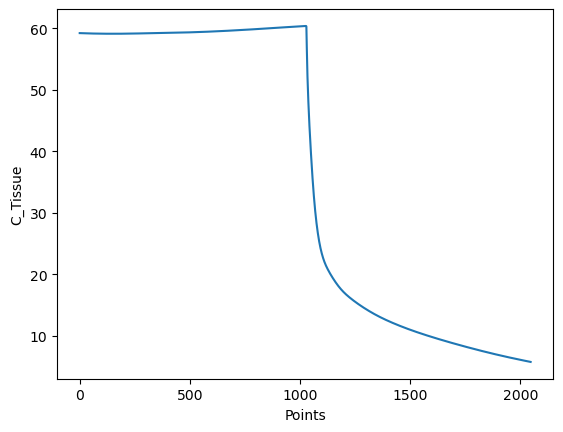

In [35]:
# Plot c_tissue4 values

plt.plot(simulated_c_tissue_values)
plt.xlabel('Points')
plt.ylabel('C_Tissue')
plt.show()

<h3> Scipy <h3>

In [39]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='same')

    # Normalize the convolution result
    num_points = len(IRF_values) 
    normalized_result_tensor = simulated_c_tissue_values / np.sqrt(num_points)

    return normalized_result_tensor


In [40]:
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 2048
IRF: 2048
[5.74026378 5.74012856 5.73999422 ... 0.55941277 0.55871327 0.55801416]
2048


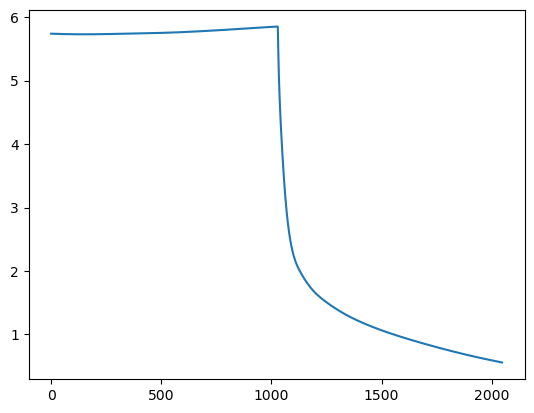

In [41]:
plt.plot(simulated_c_tissue_values)
plt.show()

<h2>Simulated TAC <h2>

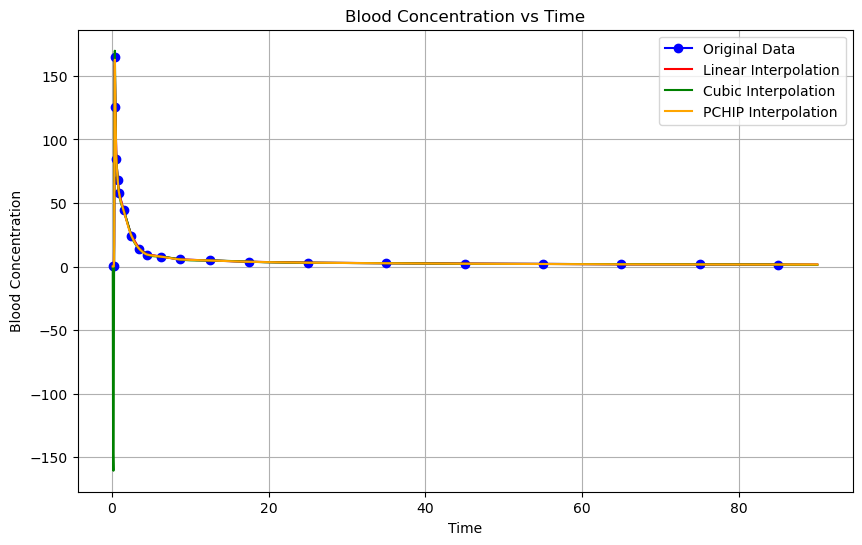

In [42]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [43]:
print("Blood values:", len(pchip_bl))
print("C_tissue", len(simulated_c_tissue_values))
print("vb:", data_from_first_row['gt_parameters_list'][3])

Blood values: 2048
C_tissue 2048
vb: 0.05


In [44]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values
    

Simulated TAC: [5.2159480612335205, 5.21707591941486, 5.2183039626378696, 5.219576305293544, 5.485736737604213, 10.958544368524233, 13.355316321341085, 12.177736869981164, 11.127864739222954, 10.293242729226748, 9.639270483163376, 9.281402698678722, 9.039362381267793, 8.853008429748158, 8.690498072862882, 8.52855592601903, 8.377002290580013, 8.246233428983551, 8.146227315119306, 8.07001663689726, 8.001411945744824, 7.9395008055551415, 7.883404125117507, 7.832196154705285, 7.785020452872782, 7.74095761182757, 7.699111326537528, 7.658601599801353, 7.61852397267152, 7.577985764078314, 7.536085233046018, 7.491949177302827, 7.445375942050919, 7.398129256438109, 7.350464416644912, 7.302507062656067, 7.254384646437521, 7.206227337927019, 7.158148093240894, 7.110280706279297, 7.062749458041068, 7.0156686636284435, 6.96916849297917, 6.923370056124987, 6.878399899041238, 6.834384567703266, 6.791447437119313, 6.749718224231825, 6.709307620180633, 6.670348965870589, 6.632965636309931, 6.5972751175

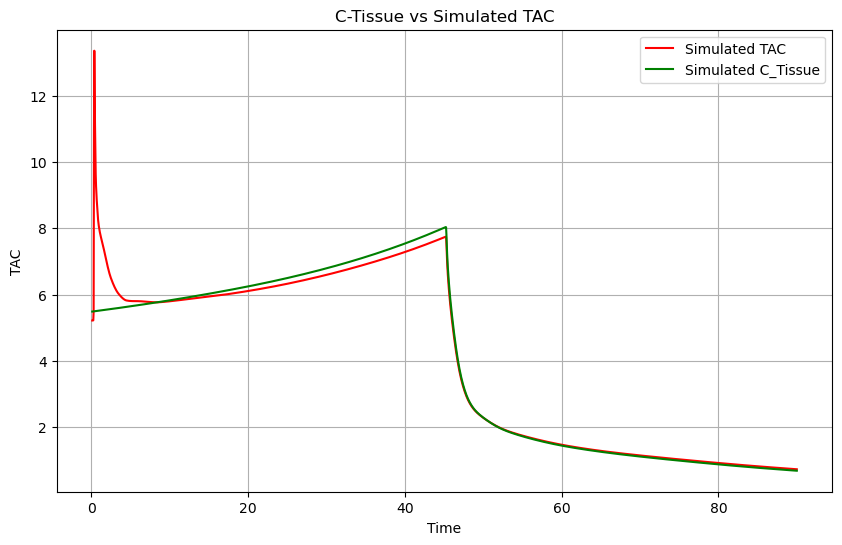

In [47]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)
print("Simulated TAC:", simulated_tac_values)
print("CTissue:" , simulated_c_tissue_values)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()

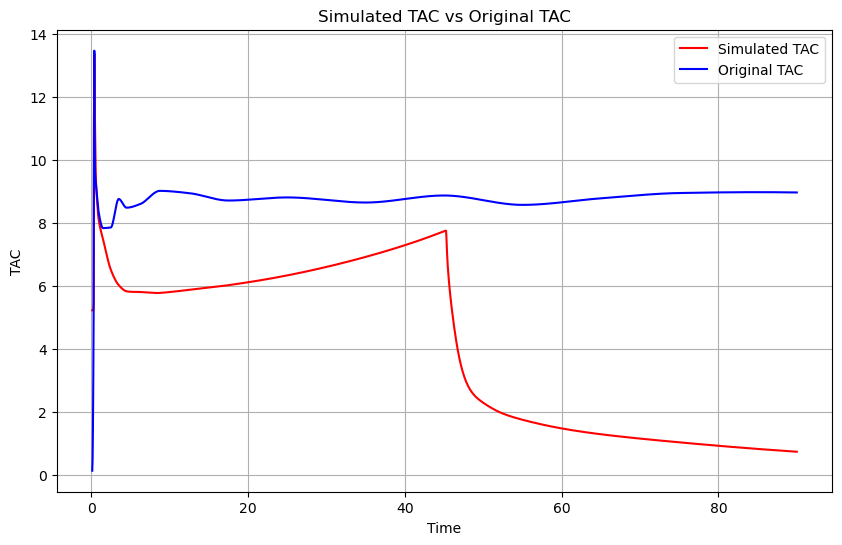

In [48]:

# Plot the simulated TAC values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Simulated TAC vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()